In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch

#import seaborn as sns # it will set to SNS style
#sns.reset_orig() # set back to the Matplotlib style
#sns.set() # set to sns style
# set the font
plt.rcParams["font.family"] = 'arial'
%matplotlib notebook

from lmfit import minimize, Model, Minimizer, Parameters, Parameter, report_fit
from scipy.signal import savgol_filter

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scipy import interpolate

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return meanx,meany,std_y #putput: nbins rows, 3 col

In [221]:
print 2.3e6/(851e6*0.2)**2, 2e6/2/(851.6e6*0.2)**2 #in s: tau = lam[s]/(gamma[rad T-1] * B[Tesla])^2 for TbSnO PRL paper
print 2*(851.6e6*0.1)**2 / (300.*2.083e10) / 1e6 # lam[\muS^-1] = 2(gamma[radT^-1]*delta[Tesla])^2 / (T[K]*2e10) / 1e6
print 2*(135e6*0.2)**2/(300.*2.083e10)/1e6
print 2e6/2/(135e6*0.2)**2
x = 1/(2e6/2/(135.6e6*0.2)**2)
x = 1/(2e6/2/(851.6e6*0.2)**2)
print "{:1.2e}".format(x), '%1.2e'%(x)

7.93978467304e-11 3.44721763758e-11
0.00232108356537
0.000233317330773
1.37174211248e-09
2.90e+10 2.90e+10


In [2]:
4*3.14*np.sin(70/180*3.14)/2.4


4.916615166986306

In [144]:
# save only one subplot
# http://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    #items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [145]:
def loaddat(fpath,fname,kwargs):
    f = os.path.join(fpath, fname);
    print f
    dat = np.genfromtxt(f,**kwargs) # kwargs is a dictionary and use'**' to convert to kwargs
    return dat[~np.isnan(dat[:,1]),:] 

def fitReg(dat, *args):
    if len(args)==1:# when the low and high limits is in a list
        mask = (args[0][0]< dat[:,0]) & (dat[:,0] < args[0][1])
    else: # two augs give the the two limits
        mask = (args[0]< dat[:,0]) & (dat[:,0] < args[1])
    return dat[mask,:]

def streExp(x,a,lam,c,beta,cons):
    return a*np.exp(-(lam*x-c)**beta)+ cons


# Ｃａｌｃｕｌａｔｅｄ　ｔｈｅ　ｃｏｒｒｅｓｐｉｎｄｉｎｇ　Ｑ　ｆｏｒ　ｔｈｅ　２ｔｈｅａｔａ　ｃｕｔ
mn = 1.675e-27 # neutron mass in Kg
hbar = 1.0546e-34 # in J s
coeffi0 = hbar**2/(2*mn) # in J m2
coeffi = hbar**2 / (2*mn) * 6.24181 * 10**21 * 10**20 # in meV A2

def clcq(ei, e, th2):
    f = ei - e; i = ei
    q = ((f + i - 2 * (f*i)**0.5 * np.cos(np.pi/180*th2))/coeffi)**0.5
    return q

## Subtract background: LaZrO, and SmZrO high angle


## Sm-a*La-b subtraction for 2theta=9deg
1. Check La background (fit or smmoth)
2. Check subtraction
3. Fit subtracted data with PV without formfactor (the fit with ff is shown in the 20deg data)

In [146]:
# Ｄｅｆｉｎｅｄ　ｆｕｎｃ　ｔｏ　ｌｏａｄ　ｄａｔａ　ａｎｄ　ｓｅｔ　ｄｉｒｃｔｏｒｙ
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO'
fname='La_SmZrO_6K_235meV_*.txt'

fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        #print(file)
        fnames.append(file)        
print '\n'.join(fnames)

loadpar = dict(skip_header=2, usecols=(0,1,2,3,4,5))

La_SmZrO_6K_235meV_I-E@20deg.txt
La_SmZrO_6K_235meV_I-E@6deg.txt
La_SmZrO_6K_235meV_I-E@9deg.txt
La_SmZrO_6K_235meV_I-E_@119deg.txt
La_SmZrO_6K_235meV_I-Q@160meV.txt
La_SmZrO_6K_235meV_I-Q_@128p5meV.txt


In [159]:
# ｌｏａｄ　ｄａｔａ：　ｌｏｗ　ａｎｇｌｅ　ａｎｄ　ａｌｓｏ　ｈｉｇｈ　ａｎｇｌｅ
dat = loaddat(fpath,'La_SmZrO_6K_235meV_I-E@9deg.txt',loadpar) # low angle 6deg data of La,Sm2Zr2O7
dat1 = loaddat(fpath,'La_SmZrO_6K_235meV_I-E_@119deg.txt',dict(usecols=(0,1))) # high angle 119deg data of Sm2Zr2O7


D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\La_SmZrO_6K_235meV_I-E@9deg.txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\La_SmZrO_6K_235meV_I-E_@119deg.txt


['a', 'lam', 'c', 'beta', 'cons']
['x']
[[Model]]
    Model(streExp)
[[Fit Statistics]]
    # function evals   = 139
    # data points      = 111
    # variables        = 3
    chi-square         = 406.005
    reduced chi-square = 3.759
    Akaike info crit   = 149.949
    Bayesian info crit = 158.077
[[Variables]]
    a:      4.0619e-09 +/- 0        (0.00%) (init= 4.0619e-09)
    lam:    0.47034688 +/- 0        (0.00%) (init= 0.1)
    c:      59 (fixed)
    beta:   1 (fixed)
    cons:   2.89723267 +/- 0        (0.00%) (init= 0)



<IPython.core.display.Javascript object>


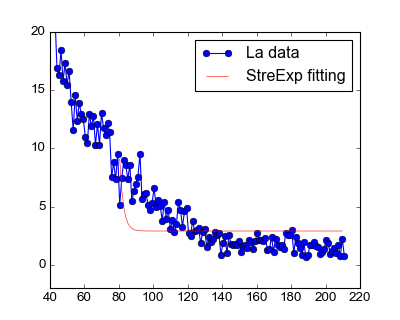

In [160]:
# Ｆｉｔ　ｔｈｅ　Ｌａ　ｄａｔａ　ｗｉｔｈ　ｓｔｒｅｃｔｈｅｄ　ｅｘｐｏｎｅｎｔｉａｌ　ｆｏｒ　ｓｕｂｔｒａｃｔｉｏｎ （ｎｏｔ　ｕｓｅｄ　ｆｏｒ　ｓｕｂｔｒａｃｉｔｏｎ）
# (use bspline is better, see below) 

mod=Model(streExp)

params = mod.make_params()
print mod.param_names
print mod.independent_vars

params['a'].set(value=4.0619e-9, vary=True, min=0, max=None)
params['lam'].set(value=0.1, vary=True, min=0, max=None)
params['c'].set(value=59, vary=False, min=0, max=None)
params['beta'].set(value=1, vary=False, min=0, max=2)
params['cons'].set(value=0, vary=True, min=None, max=None, expr='')

mask = (80< dat[:,0]) & (dat[:,0] <210) # change the fitting range
result = mod.fit(dat[mask,1], x=dat[mask,0], params = params)
print result.fit_report(modelpars=None, show_correl=False)
#print 'fitted:','\n', result.params.valuesdict()

# just smooth data
#yhat = savgol_filter(dat[mask,1], 31, 3) # window size 7, polynomial order 5

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(dat[:,0], dat[:,1], marker='o', label='La data')
ax.plot(dat[mask,0], result.best_fit, 'r-', lw=0.5, alpha=1, label='StreExp fitting') 
#ax.plot(dat[mask,0],yhat, color='b', label='local polynominal fitting')

ax.legend()
ax.set_xlim(40, 220)
ax.set_ylim(-2, 20)
plt.show()

<IPython.core.display.Javascript object>


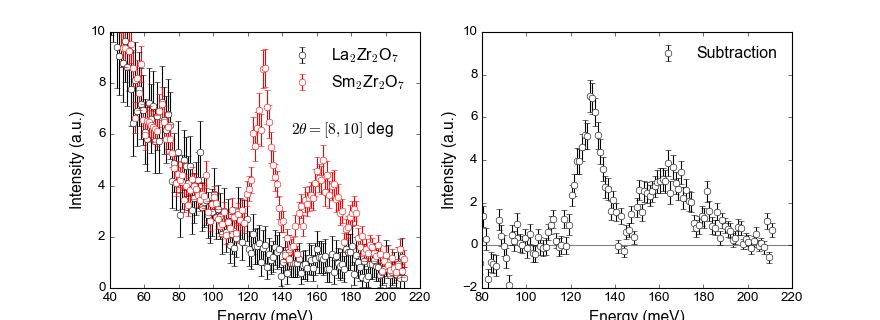

<function __main__.pltSub>

In [150]:
#　Check　Sm- a*La-b subtraction and plot
fig_label = (r'La$_2$Zr$_2$O$_7$', r'Sm$_2$Zr$_2$O$_7$','Subtraction')
print fig_label

# smooth the La data
#mask = (80< dat[:,0]) & (dat[:,0] <210) # change the fitting range
#yhat = savgol_filter(dat[mask,1], 21, 3) # window size , polynomial order 

#yinterp = interpolate.UnivariateSpline(dat[mask,0], dat[mask,1], s = 60)(dat[mask,0]) # larger s more smooth

def pltSub(x1=0,x2=0):
    global fig, axs
    axs[0].cla()  
    #axs[0].errorbar(dat[:,0], x1*dat[:,1]+x2, yerr= 0*dat[:,2],color='black', fmt='-o',label=fig_label[0])# plot a*La+b
    axs[0].errorbar(dat[:,0], x1*dat[:,1]+x2, yerr= 1*dat[:,2],mec='black', mfc='white',fmt='o',ecolor='black',label=fig_label[0])# plot a*La+b
    #axs[0].plot(dat[mask,0], x1*yhat+x2, color='r', label='Scaled local polynominal fitting') # fitted La
    #axs[0].plot(dat[mask,0], x1*yinterp+x2, label = 'Scaled Interpolated')
    axs[0].errorbar(dat[:,3], dat[:,4], yerr= 1*dat[:,5], mec='r', mfc='white',fmt='o',ecolor='r',label=fig_label[1])# plot Sm
    axs[0].legend(loc='best',numpoints=1,frameon=False)
    axs[0].text(145,6,r'$2\theta=[8,10]$ deg',fontsize=14)
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    axs[1].errorbar(dat[:,0], dat[:,4]-x1*dat[:,1]-x2, yerr=dat[:,5],fmt='o', mec='black', mfc='white',ecolor='black', label=fig_label[2])
    #axs[1].plot(dat[mask,3], result.best_fit, 'r-', lw=1, alpha=1, label='Fitting') # borrow the fitted curve (below)
    #axs[1].errorbar(dat[mask,3], dat[mask,4]-x1*yhat-x2, yerr=dat[mask,5], linestyle='-', label='sub fitted La',zorder=1)
    axs[1].legend(loc='best',numpoints=1,frameon=False)
    
    #ax.set_yscale('log')
    axs[0].set_xlim(40, 220)
    axs[0].set_ylim(0, 10)
    axs[0].set_xlabel('Energy (meV)',fontsize=14)
    axs[0].set_ylabel('Intensity (a.u.)',fontsize=14)
    axs[1].set_xlim(80, 220)
    axs[1].set_ylim(-2, 10)
    axs[1].set_xlabel('Energy (meV)',fontsize=14)
    axs[1].set_ylabel('Intensity (a.u.)',fontsize=14)

    #plt.suptitle('Sm- a*La-b for 9deg',fontsize=16)
    
    # Save just the portion _inside_ the first axis's boundaries
    # It's best to transform this back into figure coordinates. Otherwise, it won't behave correctly when the size of the plot is changed.
    #extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #extent1 = axs[0].xaxis.label.get_window_extent().transformed(fig.dpi_scale_trans.inverted())# not working
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches=extent+extent1+extent2,verbose=True)   
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches=extent.expanded(1.3, 1.3),verbose=True)
    
    extent = full_extent(axs[0], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True)
    extent = full_extent(axs[1], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La_sub.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True)
    return fig

#fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(11,4))

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.557),
         x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0))

[[Model]]
    Model(four_pv)
[[Fit Statistics]]
    # function evals   = 981
    # data points      = 102
    # variables        = 13
    chi-square         = 33.451
    reduced chi-square = 0.376
    Akaike info crit   = -87.720
    Bayesian info crit = -53.595
[[Variables]]
    A1:        78.2301009 +/- 0        (0.00%) (init= 40)
    ratio1:    0.44712291 +/- 0        (0.00%) (init= 0.5)
    mu1:       129.128634 +/- 0        (0.00%) (init= 128)
    sigma1:    3.91424774 +/- 0        (0.00%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    5.53558225 +/- 0        (0.00%) (init= 5)
    A2:        27.7383362 +/- 0        (0.00%) (init= 30)
    ratio2:    0.19877808 +/- 0        (0.00%) (init= 0.5)
    mu2:       156.838435 +/- 0        (0.00%) (init= 160)
    sigma2:    4.24264068 +/- 0        (0.00%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    6          +/- 0        (0.00%) (init= 5)
    A20:       27.7383362 +/- 0        (0.00%)  == 'A2'
    ratio20:   0.19877808 +/- 0        (0.00%) 

<IPython.core.display.Javascript object>


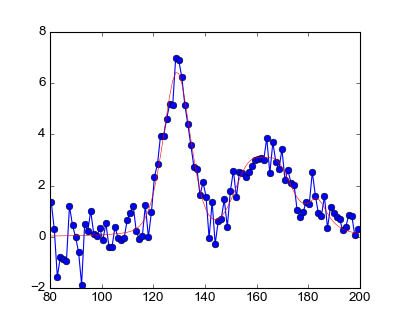

In [152]:
# Fit peak position and intensity based on the subtractd data
# with PV function ｗｉｔｈｏｕｔ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
# a cell below do the fitting ｗｉｔｈ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
def pv_func(x,A,ratio,mu,sigma,gamma):
    return A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))
    
def three_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1)+pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

def four_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3)
    
#pvmod=Model(three_pv)
pvmod=Model(four_pv)

params = pvmod.make_params()
#print pvmod.param_names
#print pvmod.independent_vars

params['A1'].set(value=40., vary=True, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=128, vary=True, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=5, vary=True, min=None, max=None)

params['A2'].set(value=30, vary=True, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=160., vary=True, min=None, max=None)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=5, vary=True, min=0, max=6)


# fit with four pv_functions and constrian the overlapping peak to have the same area
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=None, vary=False, min=0, max=None,expr='A2')
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=170., vary=True, min=None, max=None)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='sigma2')
params['gamma20'].set(value=None, vary=False, min=0, max=None,expr='gamma2')

params['A3'].set(value=10., vary=True, min=0, max=20)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=180, vary=True, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=3, vary=True, min=0, max=5)

#print params.valuesdict()

mask = (80< dat[:,0]) & (dat[:,0] <200)
dat = dat[mask,:]

result = pvmod.fit(dat[:,4]-0.557*dat[:,1], x=dat[:,3], params = params)
print result.fit_report(modelpars=None, show_correl=False)
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(dat[:,3], dat[:,4]-0.557*dat[:,1], marker='o')
ax.plot(dat[:,0], result.best_fit, 'r-', lw=0.5, alpha=1, label=fig_label[1]) 
ax.set_ylim([-2,8])
plt.show()


## Sm-a*La-b subtraction for 2theta=20deg
Load data, check subtraction, fit with PV with ff 
(the fit with ff can be change to any other data set)

In [153]:
#　ｔｈｅ　２ｔｈｅｔａ＝２０ｄｅｇ　Ｓｍ－Ｌａ　ｄａｔａ
dat = loaddat(fpath,'La_SmZrO_6K_235meV_I-E@20deg.txt',loadpar) # low angle 6deg data of La,Sm2Zr2O7

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\La_SmZrO_6K_235meV_I-E@20deg.txt


<IPython.core.display.Javascript object>


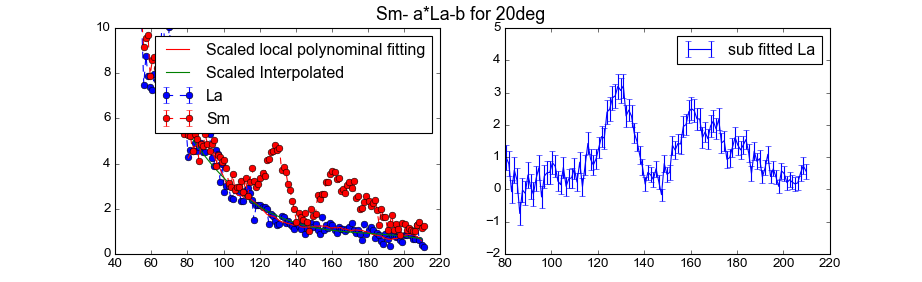

<function __main__.pltSub>

In [154]:
#　　Sm- a*La-b subtraction and plot
fig_label = (r'La', r'Sm','Subtraction')
print fig_label

# smooth the La data
mask = (80< dat[:,0]) & (dat[:,0] <210) # change the fitting range
yhat = savgol_filter(dat[mask,1], 21, 3) # window size , polynomial order 

yinterp = interpolate.UnivariateSpline(dat[mask,0], dat[mask,1], s = 60)(dat[mask,0]) # larger s more smooth


def pltSub(x1=0,x2=0):
    global fig, axs
    axs[0].cla()  
    axs[0].errorbar(dat[:,0], x1*dat[:,1]+x2, yerr= 0*dat[:,2], fmt='--o',label=fig_label[0])# plot a*La+b
    axs[0].plot(dat[mask,0], x1*yhat+x2, color='r', label='Scaled local polynominal fitting') # fitted La
    axs[0].plot(dat[mask,0], x1*yinterp+x2, label = 'Scaled Interpolated')
    axs[0].errorbar(dat[:,3], dat[:,4], yerr= 0*dat[:,5], fmt='--o',label=fig_label[1])# plot Sm
    axs[0].legend(loc='best')
    
    axs[1].cla() 
    #axs[1].errorbar(dat[:,0], dat[:,4]-x1*dat[:,1]-x2, yerr=dat[:,5], marker='o',linestyle='--', label=fig_label[2],zorder=0)
    axs[1].errorbar(dat[mask,3], dat[mask,4]-x1*yhat-x2, yerr=dat[mask,5], linestyle='-', label='sub fitted La',zorder=1)
    axs[1].legend(loc='best')
    
    #ax.set_yscale('log')
    axs[0].set_xlim(40, 220)
    axs[0].set_ylim(0, 10)
    
    axs[1].set_xlim(80, 220)
    axs[1].set_ylim(-2, 5)
    
    plt.suptitle('Sm- a*La-b for 20deg',fontsize=16)
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches="tight", verbose=True) 
    return fig

#fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.557),
         x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0))

[[Model]]
    Model(four_pv)
[[Fit Statistics]]
    # function evals   = 428
    # data points      = 111
    # variables        = 14
    chi-square         = 20.552
    reduced chi-square = 0.212
    Akaike info crit   = -159.209
    Bayesian info crit = -121.276
[[Variables]]
    A1:        62.2290710 +/- 0        (0.00%) (init= 40)
    ratio1:    0.96253014 +/- 0        (0.00%) (init= 0.5)
    mu1:       128.733885 +/- 0        (0.00%) (init= 128)
    sigma1:    4.45725563 +/- 0        (0.00%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    6.30351137 +/- 0        (0.00%) (init= 5)
    A2:        24.0872291 +/- 0        (0.00%) (init= 30)
    ratio2:    0.48412619 +/- 0        (0.00%) (init= 0.5)
    mu2:       160.295628 +/- 0        (0.00%) (init= 160)
    sigma2:    3.64424234 +/- 0        (0.00%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    5.15373694 +/- 0        (0.00%) (init= 7)
    A20:       15.4518727 +/- 0        (0.00%) (init= 20)
    ratio20:   0.48412619 +/- 0        (0.0

<IPython.core.display.Javascript object>


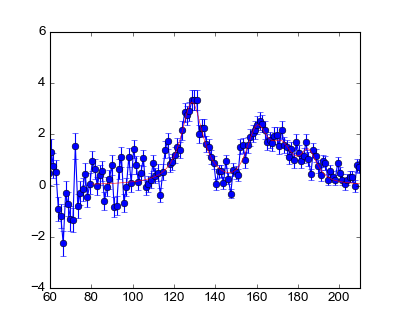

In [155]:
# Fit peak position and intensity
def pv_func(x,A,ratio,mu,sigma,gamma):
    return A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))
    
def three_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1)+pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

def four_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3)
    
#pvmod=Model(three_pv)
pvmod=Model(four_pv)

params = pvmod.make_params()
#print pvmod.param_names
#print pvmod.independent_vars

params['A1'].set(value=40., vary=True, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=128, vary=True, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=5, vary=True, min=None, max=None)

params['A2'].set(value=30, vary=True, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=160., vary=True, min=None, max=None)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=8, vary=True, min=0, max=7)


# fit with four pv_functions and constrian the overlapping peak to have the same area
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=20, vary=True, min=0, max=None,expr='')
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=170., vary=True, min=None, max=None)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='sigma2')
params['gamma20'].set(value=None, vary=False, min=0, max=None,expr='gamma2')

params['A3'].set(value=5., vary=True, min=0, max=20)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=183, vary=True, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=10, vary=True, min=2, max=5)

#print params.valuesdict()

mask = (80< dat[:,0]) & (dat[:,0] <210)

result = pvmod.fit(dat[mask,4]-0.57*dat[mask,1], x=dat[mask,3], params = params)
print result.fit_report(modelpars=None, show_correl=False)
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(dat[:,3], dat[:,4]-0.557*dat[:,1],yerr = dat[:,5], marker='o')
ax.plot(dat[mask,3], result.best_fit, 'r-', lw=0.5, alpha=1, label=fig_label[1]) 
ax.set_xlim([60,210])
ax.set_ylim([-4,6])

plt.show()

<IPython.core.display.Javascript object>


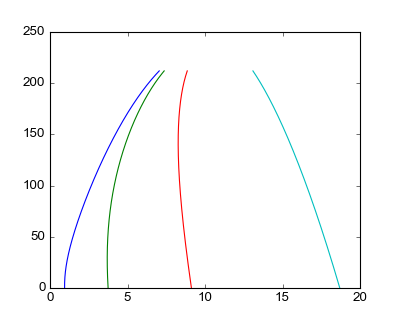

In [156]:
# Ｃａｌｃｕｌａｔｅｄ　ｔｈｅ　ｃｏｒｒｅｓｐｉｎｄｉｎｇ　Ｑ　ｆｏｒ　ｔｈｅ　２ｔｈｅａｔａ　ｃｕｔ
es = np.linspace(0,212,400)
plt.figure(figsize=[5,4])
plt.plot(clcq(241.45,es,5),es)
plt.plot(clcq(241.45,es,20),es)
plt.plot(clcq(241.45,es,50),es)
plt.plot(clcq(241.45,es,120),es)
plt.show()

<IPython.core.display.Javascript object>


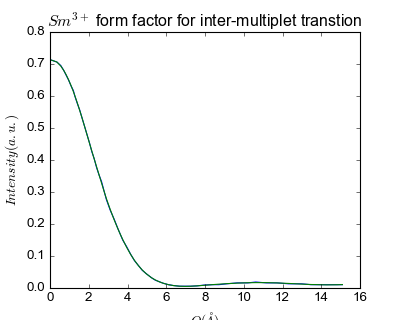

In [157]:
# Ｆｉｔ　ｐｅａｋｓ　ｗｉｔｈ　ｃｏｎｓｉｄｅｒ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ　ｆｏｒ　ｔｈｅ　２ｔｈｅａｔａ　ｃｕｔ
#　load Sm3+ form facotor for intermultiplet transitions (k/4pi vs I)
smform = np.genfromtxt(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\Sm_formfactor_intermultiplet_transition.txt',skip_header=1)
smform[:,0]=smform[:,0]*4*np.pi

# make a interplation function
spl = interpolate.UnivariateSpline(smform[:,0], smform[:,1], s = 0.0001) # larger s more smooth
#int1d = interpolate.interp1d(smform[:,0], smform[:,1], kind='cubic')

# plot to see the interplactation
plt.figure(figsize=[5,4])
plt.plot(smform[:,0],smform[:,1])
plt.plot(smform[:,0],spl(smform[:,0]))
plt.xlabel('$Q (\AA)$')
plt.ylabel('$Intensity (a.u.)$')
plt.title('$Sm^{3+}$ form factor for inter-multiplet transtion')
#plt.plot(smform[:,0],int1d(smform[:,0]))
plt.show()

[[Model]]
    Model(four_pv)
[[Fit Statistics]]
    # function evals   = 138
    # data points      = 102
    # variables        = 15
    chi-square         = 20.485
    reduced chi-square = 0.235
    Akaike info crit   = -133.741
    Bayesian info crit = -94.366
[[Variables]]
    A1:        1006.67376 +/- 286.5343 (28.46%) (init= 540)
    ratio1:    0.16159881 +/- 0.443438 (274.41%) (init= 0.5)
    mu1:       129.807223 +/- 0.292952 (0.23%) (init= 128)
    sigma1:    3.95221433 +/- 0.247033 (6.25%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    5.58927510 +/- 0.349357 (6.25%) (init= 6)
    A2:        690.619299 +/- 1.34e+03 (194.70%) (init= 600)
    ratio2:    0.01734705 +/- 1.790789 (10323.30%) (init= 0.5)
    mu2:       157.159909 +/- 13.45763 (8.56%) (init= 160)
    sigma2:    4.24210663 +/- 5.071573 (119.55%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    5.99924474 +/- 7.172287 (119.55%) (init= 6)
    A20:       1028.21228 +/- 2.99e+03 (291.03%) (init= 1000)
    ratio20:   0.01734705

<IPython.core.display.Javascript object>


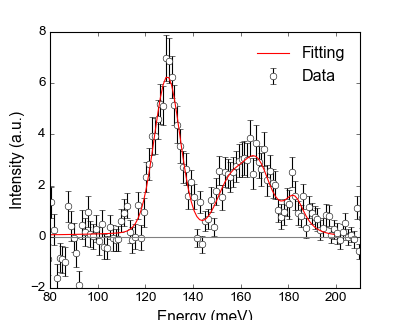

In [162]:
######################################
# ####this cell do the fitting for any 'dat' with 6 columns： xye for La and Sm
######################################
# fit aera width and postion (next cell fit only width)

# scaled pv_function
def pv_func(x,A,ratio,mu,sigma,gamma):
    return spl(clcq(241.45,x,20))* A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))
    
def three_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1)+pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

def four_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3)
    
#pvmod=Model(three_pv)
pvmod=Model(four_pv)

params = pvmod.make_params()
#print pvmod.param_names
#print pvmod.independent_vars

params['A1'].set(value=540., vary=True, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=128, vary=True, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=6, vary=True, min=None, max=None)

params['A2'].set(value=600, vary=True, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=160., vary=True, min=None, max=None)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=6, vary=True, min=0, max=6)


# fit with four pv_functions and constrian the overlapping peak to have the same area
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=1000, vary=True, min=0, max=None,expr='')
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=170., vary=True, min=None, max=None)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='gamma20/(2*log2(2))**0.5')
params['gamma20'].set(value=5, vary=True, min=0, max=6)

params['A3'].set(value=2000., vary=True, min=0, max=None)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=183, vary=True, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=5, vary=True, min=4, max=6)

#print params.valuesdict()

mask = (80< dat[:,0]) & (dat[:,0] <200)

#fit Sm-a*La
#result = pvmod.fit(dat[mask,4]-0.57*dat[mask,1], x=dat[mask,3], params = params)

#fit Sm-Smoothed(a*La)
yhat = savgol_filter(dat[mask,1], 21, 3) # window size , polynomial order 
result = pvmod.fit(dat[mask,4]-0.56*yhat, x=dat[mask,3], params = params) #######Ｔｅｌｌ　ｔｈｅ　ｓａｃａｌｅｄ　ｆａｃｔｏｒ　ｆｏｒ　ｓｕｂｔｒａｃｔｉｎｇ　Ｌａ

print result.fit_report(modelpars=None, show_correl=False)
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(dat[:,3], dat[:,4]-0.56*dat[:,1],yerr = 1.2*dat[:,5], fmt='o',mfc='white',mec='black',ecolor='black',label='Data')
ax.plot(dat[mask,3], result.best_fit, 'r-', lw=1, alpha=1, label='Fitting') 
ax.axhline(y=0.0, c='grey')
ax.set_xlim([80,210])
ax.set_ylim([-2,8])
ax.set_xlabel('Energy (meV)',fontsize=14)
ax.set_ylabel('Intensity (a.u.)',fontsize=14)
plt.legend(frameon=False, numpoints=1)
#plt.title('Fit to get peak position and intensity')
fig.savefig(os.path.join(fpath, r'Sm_La_sub_fit.pdf'), bbox_inches='tight',verbose=True)
plt.show()


In [93]:
#use 0.56 for subtraction
# calcualte the data for cef fitting
params.loads(result.params.dumps()) 
print np.array([params['A1'].value,params['A2'].value,params['A20'].value,params['A3'].value])/params['A3'].value
print np.array([params['mu1'].value,params['mu2'].value,params['mu20'].value,params['mu3'].value])

# use 0.577 for subtraciton
print np.array([937,684,1098,2556])/2556.

[ 0.37355851  0.25627639  0.38155106  1.        ]
[ 129.80722325  157.1599093   167.92427996  182.93867347]
[ 0.36658842  0.26760563  0.42957746  1.        ]


[[Model]]
    Model(four_pv)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 102
    # variables        = 8
    chi-square         = 37.874
    reduced chi-square = 0.403
    Akaike info crit   = -85.053
    Bayesian info crit = -64.053
[[Variables]]
    scale:     2736.12577 +/- 232.0122 (8.48%) (init= 1000)
    A1:        0.36 (fixed)
    ratio1:    0.15157300 +/- 0.126366 (83.37%) (init= 0.5)
    mu1:       130.23 (fixed)
    sigma1:    3.99252174 +/- 0.228600 (5.73%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    5.64627839 +/- 0.323289 (5.73%) (init= 6)
    A2:        0.23 (fixed)
    ratio2:    0.06204818 +/- 0.452582 (729.40%) (init= 0.5)
    mu2:       156.24 (fixed)
    sigma2:    3.97781196 +/- 0.230948 (5.81%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    5.62547562 +/- 0.326609 (5.81%) (init= 6)
    A20:       0.45 (fixed)
    ratio20:   0.06204818 +/- 0.452582 (729.40%)  == 'ratio2'
    mu20:      168.68 (fixed)
    sigma20:   4.12080011 +/- 0.541466 (

<IPython.core.display.Javascript object>


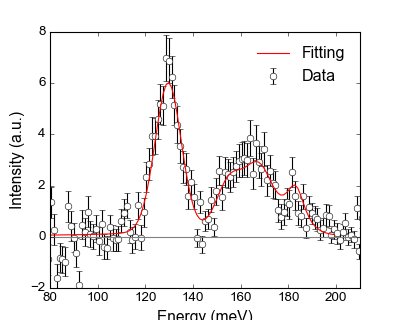

In [46]:
# Ｆｉｔ　ｐｅａｋ　ｗｉｄｔｈｓ　ｗｉｔｈ　ｆｉｘｉｎｇ　ｐｏｓ　ａｎｄ　ａｒｅａ　ｔｏ　ｂｅ　ｔｈｅ　ＣＥＦ　ｆｉｔｔｅｄ　ｖａｌｕｅｓ
def pv_func(x,A,ratio,mu,sigma,gamma):
    return spl(clcq(241.45,x,20))* A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))

def four_pv(x,scale,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return scale* ( pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3) )

pvmod=Model(four_pv)
params = pvmod.make_params()

cefa, cefmu = [0.36,0.23,0.45,1], [130.23,156.24,168.68,183.42]
params['scale'].set(value=1000, vary=True, min=0, max=None)

params['A1'].set(value=cefa[0], vary=False, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=cefmu[0], vary=False, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=6, vary=True, min=None, max=None)

params['A2'].set(value=cefa[1], vary=False, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=cefmu[1], vary=False, min=None, max=None)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=6, vary=True, min=0, max=6)


# fit with four pv_functions and constrian the overlapping peak to have the same area
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=cefa[2], vary=False, min=0, max=None,expr='')
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=cefmu[2], vary=False, min=None, max=None)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='gamma20/(2*log2(2))**0.5')
params['gamma20'].set(value=5, vary=True, min=0, max=6)

params['A3'].set(value=cefa[3], vary=False, min=0, max=None)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=cefmu[3], vary=False, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=5, vary=True, min=4, max=6)

#print params.valuesdict()

mask = (80< dat[:,0]) & (dat[:,0] <200)

#fit Sm-a*La
result = pvmod.fit(dat[mask,4]-0.56*dat[mask,1], x=dat[mask,3], params = params)

print result.fit_report(modelpars=None, show_correl=False)
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(dat[:,3], dat[:,4]-0.56*dat[:,1],yerr = 1.2*dat[:,5], fmt='o',mfc='white',mec='black',ecolor='black',label='Data')
ax.plot(dat[mask,3], result.best_fit, 'r-', lw=1, alpha=1, label='Fitting') 
ax.axhline(y=0.0, c='grey')
ax.set_xlim([80,210])
ax.set_ylim([-2,8])
ax.set_xlabel('Energy (meV)',fontsize=14)
ax.set_ylabel('Intensity (a.u.)',fontsize=14)
plt.legend(frameon=False, numpoints=1)
fig.savefig(os.path.join(fpath, r'Sm_cef_fit.pdf'), bbox_inches='tight',verbose=True)
plt.show()


## Low-High angle for Sm subtraction for 2theta=6deg and 119deg

<IPython.core.display.Javascript object>


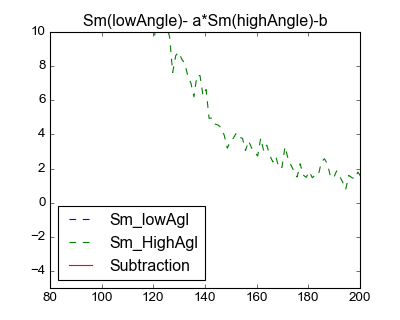

In [25]:
#　　Sm(lowAngle)- a*Sm(highAngle)-b subtraction and plot

fig_label = (r'Sm_lowAgl', r'Sm_HighAgl','Subtraction')
print fig_label

def pltSub(x1=0,x2=0):
    global fig, ax
    ax.cla()  
    ax.plot(dat[:,2], dat[:,3], label=fig_label[0],linestyle='--')
    ax.plot(dat1[:,0], dat1[:,1], label=fig_label[1],linestyle='--')
    ax.plot(dat[:,2], dat[:,3]-x1*dat1[:,1]-x2, label=fig_label[2])
    #ax.set_yscale('log')
    ax.set_xlim(80, 200)
    ax.set_ylim(-5, 10)
    
    plt.legend(loc='best')
    plt.title('Sm(lowAngle)- a*Sm(highAngle)-b')
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches="tight", verbose=True) 
    return fig

fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.11),
         x2=widgets.FloatSlider(min=-20,max=20,step=1,value=0))

## Formfactor of Sm$^{3+}$ for intermultiplet transition

In [182]:
# ｌｏａｄ　ｄａｔａ：　
#Data I-Q for La,Sm2Zr2O7 at 128.5meV
ff = ['La_SmZrO_6K_235meV_I-Q_@128p5meV.txt','La_SmZrO_6K_235meV_I-Q@160meV.txt']
dat = loaddat(fpath,ff[0],loadpar) 
# the thory I=Q data for Sm form factor
smform = np.genfromtxt(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\Sm_formfactor_intermultiplet_transition.txt',skip_header=1)
#print smform
nbins = 90
dla = lin_binning(dat[:,0], dat[:,1],nbins)
dnd = lin_binning(dat[:,3], dat[:,4],nbins)
dat = np.vstack([dla,dnd]).T
#print dat

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\La_SmZrO_6K_235meV_I-Q_@128p5meV.txt


<IPython.core.display.Javascript object>


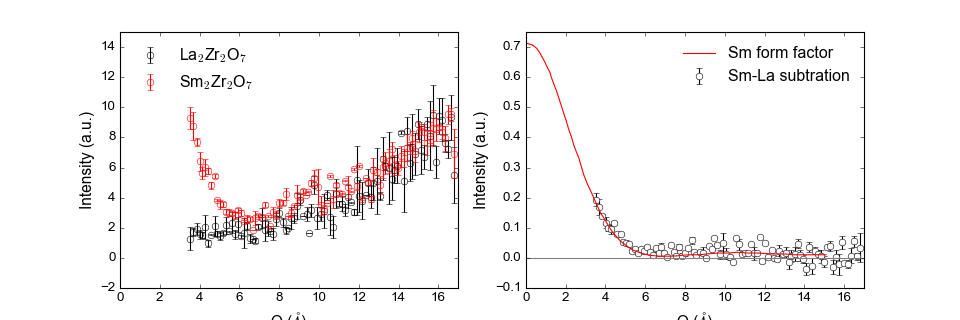

<function __main__.pltSub>

In [186]:
%matplotlib notebook
# # form factor at 128meV　: Sm- a*La-b subtraction and plot
fig_label = (r'La$_2$Zr$_2$O$_7$', r'Sm$_2$Zr$_2$O$_7$','Subtraction')
# Two methods: try to smooth La data
#yhat = savgol_filter(dat[:,1], 71, 0) # window size , polynomial order 
#yinterp = interpolate.UnivariateSpline(dat[:,0], dat[:,1], s = 5e8)(dat[:,0]) # larger s more smooth

def pltSub(x1,x2,x3,x4):# x1 and x2 for subtration, x3 and x4 for matching theory to data
    global fig, axs
    axs[0].cla()  
    #axs[0].plot(dat[:,0], dat[:,1], label=fig_label[0],linestyle='-')
    axs[0].errorbar(dat[:,0], x1*dat[:,1]+x2, yerr= 1*dat[:,2], fmt='o',mfc='none',mec='black',ecolor='black',label=fig_label[0])# plot a*La+b
    #axs[0].plot(dat[:,0], x1*yhat+x2, color='r', label='Scaled fitted La') # fitted La
    #axs[0].plot(dat[:,0], x1*yinterp+x2, label = 'Interpolated')
    axs[0].errorbar(dat[:,3], dat[:,4], yerr= 1*dat[:,5], fmt='o',mfc='none',mec='r',ecolor='r',label=fig_label[1])# plot Sm
    #axs[0].plot(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, label=fig_label[2]) # plot subtraction
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    #axs[1].errorbar(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, yerr=dat[:,5],fmt='o', label=fig_label[2])
    axs[1].errorbar(dat[:,3], x3*(dat[:,4]-x1*dat[:,1]-x2)+x4, yerr=x3*1.2*dat[:,5],fmt='o',mfc='white',mec='black',ecolor='black', label='Sm-La subtration',zorder=1)
    axs[1].plot(smform[:,0]*4*np.pi, smform[:,1],'r-',label='Sm form factor')
    axs[0].set_xlim(0, 17)
    axs[0].set_ylim(-2, 15)
    axs[0].legend(loc='best',frameon=False, numpoints=1)
    axs[0].set_xlabel('Q ($\AA$)',fontsize=14)
    axs[0].set_ylabel('Intensity (a.u.)',fontsize=14)
    
    axs[1].set_xlim(0, 17)
    axs[1].set_ylim(-0.1, 0.75)
    axs[1].legend(loc='best',frameon=False, numpoints=1)
    axs[1].set_xlabel('Q ($\AA$)',fontsize=14)
    axs[1].set_ylabel('Intensity (a.u.)',fontsize=14)
    # Fialed: try to remove the blank left end in the save first subplot:if set subplots have thems xlim, fine
    #fig.tight_layout()# remove the left blank of subplot 1
    #plt.subplots_adjust(left=0.1)#, bottom=0.1, right=1.1, top=1.1, wspace=0.1, hspace=0)
    #plt.suptitle('Sm- a*La-b (FormFactor @ 128meV)')
    
    #fig.delaxes(axs[1])
    extent = full_extent(axs[0], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(fpath, r'Sm_La_form.pdf'), bbox_inches=extent.expanded(1.02,1.02))
    extent = full_extent(axs[1], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(fpath, r'Sm_La_form_sub.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True) 

    return fig

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(12, 4),gridspec_kw = {'width_ratios':[1, 1]})

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.58),
                 x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0),
                 x3=widgets.FloatSlider(min=0,max=0.05,step=0.001,value=0.024),
                 x4=widgets.FloatSlider(min=-0.02,max=0.02,step=0.001,value=-0.000)) #old x1=0.55,x4=-0.008

<IPython.core.display.Javascript object>


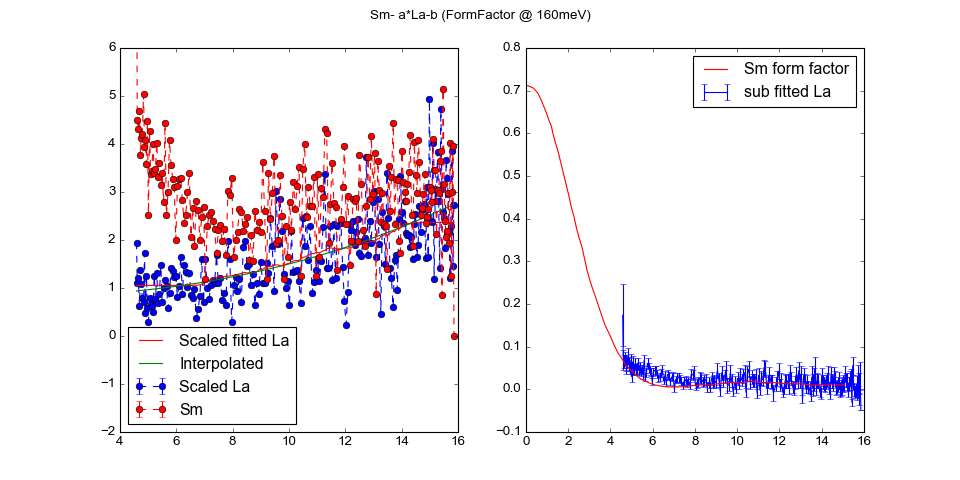

<function __main__.pltSub>

In [29]:
# form factor at 160meV: Sm- a*La-b subtraction and plot

dat = loaddat(fpath,ff[1],loadpar) 

fig_label = (r'La', r'Sm','Subtraction')

# Two methods: try to smooth La data
yhat = savgol_filter(dat[:,1], 71, 0) # window size , polynomial order 
yinterp = interpolate.UnivariateSpline(dat[:,0], dat[:,1], s = 5e8)(dat[:,0]) # larger s more smooth

def pltSub(x1,x2,x3,x4): # x1 and x2 for subtration, x3 and x4 for matching theory to data
    global fig, axs
    axs[0].cla()  
    #axs[0].plot(dat[:,0], dat[:,1], label=fig_label[0],linestyle='-')
    axs[0].errorbar(dat[:,0], x1*dat[:,1]+x2, yerr= 0*dat[:,2], fmt='--o',label='Scaled La')# plot a*La+b
    axs[0].plot(dat[:,0], x1*yhat+x2, color='r', label='Scaled fitted La') # fitted La
    axs[0].plot(dat[:,0], x1*yinterp+x2, label = 'Interpolated')
    axs[0].errorbar(dat[:,3], dat[:,4], yerr= 0*dat[:,5], fmt='--o',label=fig_label[1])# plot Sm
    #axs[0].plot(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, label=fig_label[2]) # plot subtraction
    
    axs[1].cla() 
    #axs[1].errorbar(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, yerr=dat[:,5],fmt='o', label=fig_label[2])
    axs[1].errorbar(dat[:,3], x3*(dat[:,4]-x1*yhat-x2)+x4, yerr=x3*dat[:,5], linestyle='-', label='sub fitted La',zorder=1)
    axs[1].plot(smform[:,0]*4*np.pi, smform[:,1],'r-',label='Sm form factor')
    #ax.set_xlim(80, 200)
    axs[0].set_ylim(-2, 6)
    axs[0].legend(loc='best')
    axs[1].set_ylim(-0.1, 0.8)
    axs[1].legend(loc='best')
    
    plt.suptitle('Sm- a*La-b (FormFactor @ 160meV)')
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches="tight", verbose=True) 
    return fig

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False,figsize=(12, 6))

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.42),
                 x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0),
                 x3=widgets.FloatSlider(min=0,max=0.06,step=0.001,value=0.02),
                 x4=widgets.FloatSlider(min=-1,max=1,step=0.01,value=0)) 

<IPython.core.display.Javascript object>


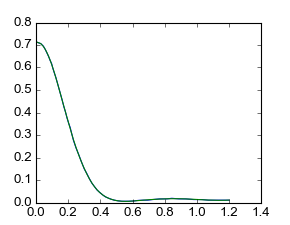

In [55]:
# fit the form factor
spl = interpolate.UnivariateSpline(smform[:,0], smform[:,1], s = 0.0001) # larger s more smooth
int1d = interpolate.interp1d(smform[:,0], smform[:,1], kind='cubic')

plt.figure()
plt.plot(smform[:,0],smform[:,1])
plt.plot(smform[:,0],spl(smform[:,0]))
#plt.plot(smform[:,0],int1d(smform[:,0]))
plt.show()

In [56]:
# Load the 39mev_I-E@13and119deg data
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO'
fname='SZO_5K_39meV_I-E*.txt'

fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        fnames.append(file)
        
print '\n'.join(fnames)

loadpar = dict(skip_header=2, usecols=(0,1))
dat0 = loaddat(fpath,fnames[1],loadpar) 
dat1 = loaddat(fpath,fnames[2],loadpar)

SZO_5K_39meV_I-E_@111deg.txt
SZO_5K_39meV_I-E_@119deg.txt
SZO_5K_39meV_I-E_@13deg.txt
SZO_5K_39meV_I-E_@lowAngle.txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SZO_5K_39meV_I-E_@119deg.txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SZO_5K_39meV_I-E_@13deg.txt


<IPython.core.display.Javascript object>


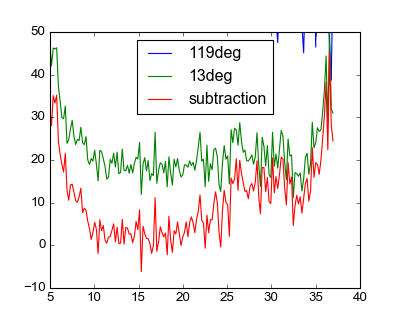

<function __main__.pltSub>

In [57]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

% matplotlib notebook

fig_label = (r'119deg', r'13deg','subtraction')
print fig_label

def pltSub(x1=0,x2=0):
    global fig, ax
    ax.cla()  
    ax.plot(dat0[:,0], dat0[:,1], label=fig_label[0])
    ax.plot(dat1[:,0], dat1[:,1],label=fig_label[1])
    ax.plot(dat1[:,0], dat1[:,1]-x1*dat0[:,1]+x2,label=fig_label[2])
    #ax.set_yscale('log')
    ax.set_xlim(5, 40)
    ax.set_ylim(-10, 50)
    plt.legend(loc='best')
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches="tight", verbose=True) 
    return fig

fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.5,step=0.01,value=0.1),
         x2=widgets.FloatSlider(min=-20,max=20,step=1,value=0)) 


In [58]:
# load dat
f = os.path.join(fpath,r'SZO_5K_250meV_I-E_@11&111deg.txt')
dat = np.genfromtxt(f, skip_header=4, usecols=(0,1))
l = len(dat)
dat0=dat[:l/2,:]
dat1=dat[l/2:,:]
#print dat0, dat1

<IPython.core.display.Javascript object>


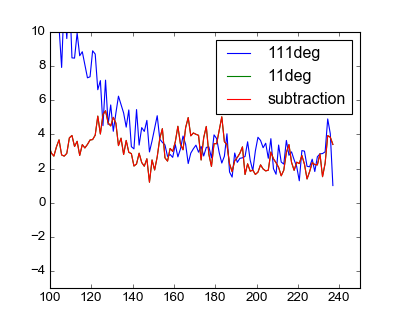

<function __main__.pltSub>

In [59]:
fig_label = (r'111deg', r'11deg','subtraction')
print fig_label

def pltSub(x1=0,x2=0):
    global fig, ax
    ax.cla()  
    ax.plot(dat0[:,0], dat0[:,1], label=fig_label[0])
    ax.plot(dat1[:,0], dat1[:,1],label=fig_label[1])
    ax.plot(dat1[:,0], dat1[:,1]-x1*dat0[:,1]+x2,label=fig_label[2])
    #ax.set_yscale('log')
    ax.set_xlim(100, 250)
    ax.set_ylim(-5, 10)
    plt.legend(loc='best')
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches="tight", verbose=True) 
    return fig

fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.5,step=0.01,value=0),
         x2=widgets.FloatSlider(min=-20,max=20,step=1,value=0)) 

In [61]:
# Ｒｅａｄ　ａｎｄ　ｐｌｏｔ　ｔｈｅ　Ｉ（Ｅ）　ｄａｔａ　ａｔ　ｄｉｆｆｅｒｅｎｔ　Ｑｓ　ｆｏｒ　ＳｍＺｒＯ　ａｎｄ　ＬａＺｒＯ　ｗｉｔｈ　Ｅｉ　３９ｍｅＶ　ａｔ　～６Ｋ
fnames = [r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\LZO_5K_39meV_I-E_Qs.txt',
          r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SZO_6p8K_39meV_I-E_Qs.txt']
# the first data is [4,5]Q
def readDave(fname):
    data = np.empty((200,24))# 200 nb of e pts, 8 nb of q pts (e,i,di)
    data[:] = np.nan
    Qr = []
    with open(fname, 'rU') as f:
        j = -1
        for line in f:        
            line=line.rstrip('\n').split() # without giving delimenter, it will treat conseutive space as one
            if line[0]=="line": # read the title
                Qr.append([line[2][5],line[2][7]])
                i = 0 # restart new dataset
                j = j + 1 # restart new dataset           
            elif line[0]!="x": # skip the header
                data[i,j*3:(j+1)*3] = np.array(line[0:3],dtype='f8')
                i = i + 1
    return Qr, data
Qr, data0 = readDave(fnames[0])
_, data1 = readDave(fnames[1])
#print Qr, data  
print data0.shape, data1.shape

(200L, 24L) (200L, 24L)


8


<IPython.core.display.Javascript object>


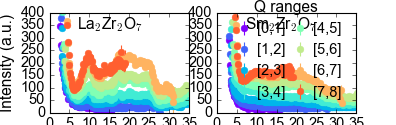

In [140]:
# Plot 
print len(Qr)

import matplotlib.colors as mcolor
import matplotlib.cm as cm

# Make a user-defined colormap.
cm1 = mcolor.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
cm1 = plt.cm.rainbow
# Make a normalizer that will map the values
cnorm = mcolor.Normalize(vmin=0,vmax=len(Qr))
# Turn these into an object that can be used to map values to colors and can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])


colors = ['r','k','b','y','g','c','m','orange']
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12,4))

# for i in np.arange(len(Qr)):# loop over Qs
#     data = data0
#     axs[0].errorbar(data[:,i*3],data[:,i*3+1],data[:,i*3+2], fmt='o',markersize='6', 
#                     mec=colors[i], ecolor=colors[i], mfc='white', label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
#     data = data1
#     axs[1].errorbar(data[:,i*3],data[:,i*3+1],data[:,i*3+2], fmt='o',markersize='6', 
#                     mec=colors[i], ecolor=colors[i], mfc='white', label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
    
for idx, i in enumerate([1,2,3,4,0,5,6,7]):# loop over Qs
    data = data0
    axs[0].errorbar(data[:,i*3],data[:,i*3+1],data[:,i*3+2], fmt='o',markersize='6', capsize=0,
                    mec=cpick.to_rgba(idx), ecolor=cpick.to_rgba(idx), mfc=cpick.to_rgba(idx), label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
    data = data1
    axs[1].errorbar(data[:,i*3],data[:,i*3+1],data[:,i*3+2], fmt='o',markersize='6', capsize=0,
                    mec=cpick.to_rgba(idx), ecolor=cpick.to_rgba(idx), mfc=cpick.to_rgba(idx), label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')

axs[0].text(7,350,'La$_2$Zr$_2$O$_7$',size=14, ha='left', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  
axs[1].text(7,350,'Sm$_2$Zr$_2$O$_7$',size=14, ha='left', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  

axs[0].set_xlabel('Energy (meV)',fontsize=14)
axs[1].set_xlabel('Energy (meV)',fontsize=14)
axs[0].set_ylabel('Intensity (a.u.)',fontsize=14)

axs[0].tick_params(axis='both', which='major', labelsize=13)
axs[1].tick_params(axis='both', which='major', labelsize=13)

axs[0].set_xlim([0,35])
axs[1].set_xlim([0,35])
axs[0].set_ylim([0,400])
axs[1].set_ylim([0,400])

# Plot legend
axs[1].legend(fontsize=14,loc='best',numpoints=1,ncol=2,frameon=False)
handles,labels = axs[1].get_legend_handles_labels()

# Change the order of the legend： because the first one is Q[4,5]: For in np.arange(len(Qr)):# loop over Qs
# handles.insert(4, handles.pop(0))# this statement does the job but returns 'none', not put in 'legend()'
# labels.insert(4, labels.pop(0))

leg = axs[1].legend(handles,labels,fontsize=13,loc='best',numpoints=1,ncol=2,handletextpad=-0.1,
                    columnspacing=-0.0, frameon=False,title='Q ranges')
leg.get_title().set_fontsize('14') # OR plt.setp(leg.get_title(),fontsize='14')

fig.savefig(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\LaSmZO_5K_39meV_I-E_Qs.pdf', bbox_inches='tight',verbose=True)  
plt.show()

In [40]:
#print np.isnan(data0[:,1])
#mask = ~np.isnan(data0[:,1])
print data1[:,1].shape
print data0[:,1].shape
#print np.isnan(data1[:,1])==np.isnan(data0[:,1])
#data0[~np.isnan(data0[:,1]), 1]
#savgol_filter(data1[mask,1],5,3)

(200L,)
(200L,)


<IPython.core.display.Javascript object>


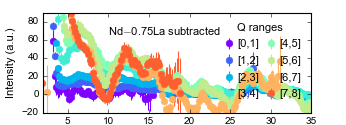

<function __main__.pltSub>

In [141]:
from scipy.signal import savgol_filter

def pltSub(x1=0,x2=1,ylim1=0,ylim2=400):
    global fig, ax
    ax.cla()
    #colors = ['r','k','b','y','g','c','m','orange']
    for idx, i in enumerate([1,2,3,4,0,5,6,7]):# loop over Qs

        y1, y0 = data1[:,i*3+1].copy(), data0[:,i*3+1].copy()
        
        #ax.errorbar(data1[:,i*3], y1-x2*y0, 1.4*data1[:,i*3+2], fmt='o',markersize='6',  capsize=0,
                        #mec=cpick.to_rgba(idx), ecolor=cpick.to_rgba(idx), mfc=cpick.to_rgba(idx), label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')

        mask1, mask0= ~np.isnan(y1), ~np.isnan(y0)
        y1[mask1], y0[mask0] = savgol_filter(y1[mask1],7,3), savgol_filter(y0[mask0],7,3)
                       
        #ax.scatter(data1[:,i*3],y1-x2*y0, c=cpick.to_rgba(idx),alpha=1, label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
        
        ax.errorbar(data1[:,i*3], y1-x2*y0, 1.4*data1[:,i*3+2], fmt='o',markersize='6',  capsize=0,
                        mec=cpick.to_rgba(idx), ecolor=cpick.to_rgba(idx), mfc=cpick.to_rgba(idx), label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
        #ax.scatter(data1[:,i*3],data1[:,i*3+1]-x2*data0[:,i*3+1], c=colors[i],alpha=0.5, label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
    #plt.colorbar(cpick,label="Time (seconds)")
    
    ax.text(10,70,'Nd$-$%2.2fLa subtracted'%(x2),size=10, ha='left', va='center',
        backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))  
    
    ax.set_xlim([2,35])
    ax.set_ylim([ylim1,ylim2])
    
    leg = ax.legend(title='Q ranges',fontsize=10,loc='best', handletextpad=-0.2, 
                    labelspacing=0.6, scatterpoints=1, numpoints=1,ncol=2,columnspacing=0.0,frameon=False)#,title='Q ranges')
    leg.get_title().set_fontsize('10') # OR plt.setp(leg.get_title(),fontsize='14')
    leg.draggable()
    ax.set_xlabel('Energy (meV)',fontsize=10)
    ax.set_ylabel('Intensity (a.u.)',fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.tick_params(axis='both', which='major', labelsize=9)
    #fig.savefig(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\LaSmZO_5K_39meV_I-E_Qs_sub.pdf', bbox_inches="tight", verbose=True) 
    return fig

fig, ax = plt.subplots(figsize=(8, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})

interact(pltSub, 
         x1=widgets.FloatSlider(min=0,max=100,step=5,value=0),
         x2=widgets.FloatSlider(min=0.5,max=0.9,step=0.05,value=0.75),
         ylim1=widgets.FloatSlider(min=-100,max=20,step=10,value=-20),
         ylim2=widgets.FloatSlider(min=50,max=200,step=5,value=90)
        ) 

In [142]:
fig.savefig(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\LaSmZO_5K_39meV_I-E_Qs_sub.pdf', bbox_inches="tight", verbose=True) 

<IPython.core.display.Javascript object>


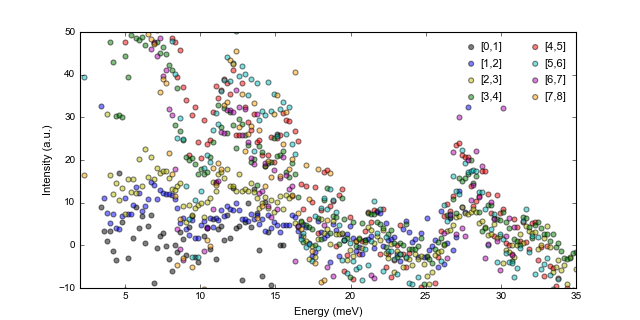

<function __main__.pltSub>

In [70]:
def pltSub(x1=0,x2=1,ylim1=0,ylim2=400):
    global fig, ax
    ax.cla()
    colors = ['r','k','b','y','g','c','m','orange']
    for i in np.arange(len(Qr)):# loop over Qs
        #ax.errorbar(data1[:,i*3],data1[:,i*3+1]-x2*data0[:,i*3+1],0.01*data1[:,i*3+2], fmt='o',markersize='6', 
                        #mec=colors[i], ecolor=colors[i], mfc='none', label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
        ax.scatter(data1[:,i*3],data1[:,i*3+1]-x2*data0[:,i*3+1], c=colors[i],alpha=0.5, label='[' + Qr[i][0] + ','+ Qr[i][1] + ']')
    
    ax.set_xlim([2,35])
    ax.set_ylim([ylim1,ylim2])
    
    ax.legend(fontsize=14,loc='best',numpoints=1,ncol=2,frameon=False)
    handles,labels = ax.get_legend_handles_labels()
    handles.insert(4, handles.pop(0))# this statement does the job but returns 'none', not put in 'legend()'
    labels.insert(4, labels.pop(0))
    leg = ax.legend(handles,labels,fontsize=10,loc='best', handletextpad=-0.2, labelspacing=0.6, scatterpoints=1, numpoints=1,ncol=2,frameon=False)#,title='Q ranges')
    leg.get_title().set_fontsize('14') # OR plt.setp(leg.get_title(),fontsize='14')
    ax.set_xlabel('Energy (meV)',fontsize=10)
    ax.set_ylabel('Intensity (a.u.)',fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.tick_params(axis='both', which='major', labelsize=9)
    #fig.savefig(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\LaSmZO_5K_39meV_I-E_Qs_sub.pdf', bbox_inches="tight", verbose=True) 
    return fig

fig, ax = plt.subplots(figsize=(8, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})

interact(pltSub, 
         x1=widgets.FloatSlider(min=0,max=100,step=5,value=0),
         x2=widgets.FloatSlider(min=0,max=2,step=0.1,value=0.8),
         ylim1=widgets.FloatSlider(min=-100,max=20,step=10,value=-10),
         ylim2=widgets.FloatSlider(min=20,max=400,step=10,value=50)
        ) 

<IPython.core.display.Javascript object>


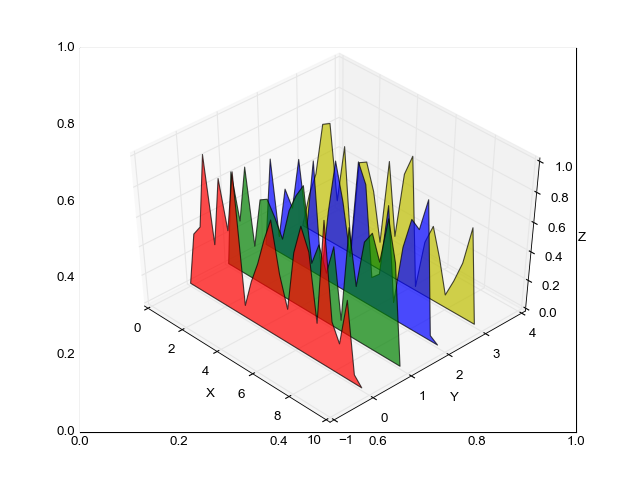

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

fig,ax = plt.subplots()
ax = fig.gca(projection='3d')


def cc(arg):
    return mcolors.colorConverter.to_rgb(arg)

xs = np.arange(0, 10, 0.4)
verts = []
zs = [0.0, 1.0, 2.0, 3.0]
for z in zs:
    ys = np.random.rand(len(xs))
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[cc('r'), cc('g'), cc('b'),
                                         cc('y')])
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')

ax.set_xlabel('X')
ax.set_xlim3d(0, 10)
ax.set_ylabel('Y')
ax.set_ylim3d(-1, 4)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 1)

plt.show()

## Formfactor of Sm$^{3+}$ provided by Prof. A. Boothroyd

In [52]:
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO/'
fname='Sm_formfact_andrew_*.txt'

fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        #print(file)
        fnames.append(file)        
print '\n'.join(fnames)

ff0 = np.genfromtxt(os.path.join(fpath,fnames[0]),skip_header=3)# use PrSnO parameters
ff1 = np.genfromtxt(os.path.join(fpath,fnames[1]),skip_header=3)# use TbTiO parameters
print ff0.shape,ff1.shape

Sm_formfact_andrew_prsno.txt
Sm_formfact_andrew_tbtio.txt
(21L, 14L) (21L, 14L)


<IPython.core.display.Javascript object>


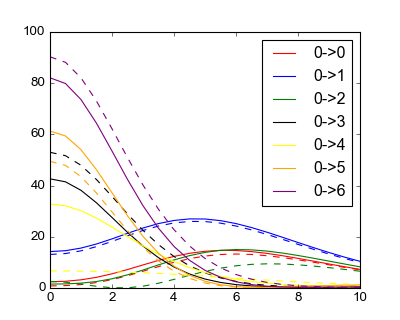

In [53]:
fig = plt.figure(figsize=[5,4])
color = ['r','b','g','k','yellow','orange','purple']
legs = ['0->0','0->1','0->2','0->3','0->4','0->5','0->6']
for i in xrange(ff0.shape[1]/2):
    plt.plot(ff0[:,i*2],ff0[:,i*2+1],linestyle='-',color=color[i],label=legs[i])
    plt.plot(ff1[:,i*2],ff1[:,i*2+1],linestyle='--',color=color[i])
plt.legend(loc='best')
plt.show()    